**This is a notebook of solving Cahn-Hilliard equaqtion with spectral method with both CPU and GPU.**

Benchmark problem 1: https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/

**Contributor**: Qian (Jennifer) Zhang, INL, qian.jennifer.zhang@gmail.com

**Free energy functional**:

$$F=\int_V (f_{chem}+\frac{\kappa}{2}|\nabla c|^2) dx$$

where $f_{chem}$ is the chemical free energy density and $\kappa$ is the gradient energy coefficient. For this problem, we choose $f_{chem}$ to have a simple polynomial form,

$$f_{chem}(c) = \rho_s(c-c_\alpha)^2(c-c_\beta)^2$$

**The Cahn-Hilliard Equation** is

$$\frac{\partial c}{\partial t}=\nabla\cdot[M\nabla(\frac{\partial f_{chem}}{\partial c}-\kappa \Delta c)]$$

$+$ Period boundary condition

The difficulty here is that a trivial semi-implicit time discretisation
$$
   c^{n+1} + M\kappa \Delta t \Delta^2 c^{n+1} = c^{n} + M\Delta t \Delta (\frac{\partial f_{chem}}{\partial c})
$$
has time-step restriction due to the non-convexity of $f_{chem}$. We propose a convex splitting algorithm such as
$$
   (1 + M\kappa\Delta t \Delta^2 - \alpha M\Delta t \Delta) c^{n+1} 
    = (1-\alpha M \Delta t \Delta) c^{n} + M\Delta t \Delta (\frac{\partial f_{chem}}{\partial c}).
$$
Since $$\frac{\partial f_{chem}}{\partial c} = 2 \rho_s(c-c_\alpha)(c-c_\beta)(2c-c_\alpha-c_\beta) \in [-2\rho_s c_\alpha c_\beta, 2\rho_s c_\alpha c_\beta],$$so we need $\alpha \geq 2 \rho_s c_\alpha c_\beta$ to get $\Delta t$-independent stability. 

In reciprocal space, the next time step updating equation becomes
$$
  (1 + M\kappa\Delta t |k|^4 + \alpha M \Delta t |k|^2) \hat{c}^{n+1} = \big(1 + \alpha M\Delta t |k|^2 \big) \hat{c}^{n} - M \Delta t |k|^2 (\widehat{\frac{\partial f_{chem}}{\partial c}})^{n}
$$

**The efficiency of the code**:

128$\times$128$\times$128 (3000 time steps):

1. Single CPU: 1109.6s
2. Cupy GPU: 6.8s
3. Manually dispatch the job: 2.8s

256$\times$256$\times$256 (3000 time steps):

1. Single CPU: ---
2. Cupy GPU: 52.64s
3. Manually dispatch the job: 21.09s 

384$\times$384$\times$384 (3000 time steps):

1. Single CPU: ---
2. Cupy GPU:185.38s
3. Manually dispatch the job: 76.15s

**Note for spectrual method, there is not much room for efficiency improvement for mamually dispatching due to the efficiency limitation introduced by implementing FFT and inverse FFT with cupy.**

<font color='blue'>**Content of this notebook:**</font>

1. Check computational resource

2. Load packages

3. Several Visualization tools

4. Section 1: single CPU

5. Section 2: Cupy GPU

6. Section 3: Manually dispatching GPU

7. Section 4: Convex splitting

In [19]:
## Check computational resource

import pyopencl as cl

platforms = cl.get_platforms()
for platform in platforms:
    devices = platform.get_devices()
    for device in devices:
        print(f"Device Name: {device.name}")
        print(f"Device Type: {cl.device_type.to_string(device.type)}")
        print(f"Compute Units (similar to cores): {device.max_compute_units}")

Device Name: Tesla V100-SXM2-32GB
Device Type: ALL | GPU
Compute Units (similar to cores): 80


In [21]:
## load packages

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import time

In [20]:
## Several Visualization tools

def visualize_3d_cpu(c_init,n):
    c_init=c_init
    x, y, z = np.meshgrid(np.arange(c_init.shape[0]),
                      np.arange(c_init.shape[1]),
                      np.arange(c_init.shape[2]))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Flatten the arrays to 1D
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    data = c_init.flatten()

    # Scatter plot
    ax.scatter(x, y, z, c=data, cmap='bwr')

    # Add labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Add title
    ax.set_title('concentration at T='+str(n))

    # Show the plot
    plt.show()


##function of visualization gpu
def visualize_3d_gpu(c_init,n):
    c_init=c_init.get()
    x, y, z = np.meshgrid(np.arange(c_init.shape[0]),
                      np.arange(c_init.shape[1]),
                      np.arange(c_init.shape[2]))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Flatten the arrays to 1D
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    data = c_init.flatten()

    # Scatter plot
    ax.scatter(x, y, z, c=data, cmap='bwr')

    # Add labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Add title
    ax.set_title('concentration at T='+str(n))

    # Show the plot
    plt.show()

def visualize_slice_cpu(c_init):
    slice_index = c_init.shape[2] // 2  # Take the middle slice along the z-axis
    c_slice = c_init[:, :, slice_index]  # Transfer the slice to CPU for visualization

    plt.imshow(c_slice, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title('Middle slice of the concentration field at the final time step')
    plt.show()

def visualize_slice_gpu(c_init):
    slice_index = c_init.shape[2] // 2  # Take the middle slice along the z-axis
    c_slice = c_init[:, :, slice_index].get()  # Transfer the slice to CPU for visualization

    plt.imshow(c_slice, cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.title('Middle slice of the concentration field at the final time step')
    plt.show()

<font color='blue'>**Section 1: Single CPU**</font>

In [3]:
##Method 1: CPU

##function of solve the equation
class solver_CH():
    def __init__(self, rho, kappa, M, ca, cb, alpha):
        self.rho = rho
        self.kappa = kappa
        self.M = M
        self.ca = ca
        self.cb = cb
        self.alpha = alpha
        
    def dfchemdc(self,w):
        return 2.0*self.rho*(w-self.ca)*(w-self.cb)*(2.0*w-self.ca-self.cb)
        
    def Solve_CH(self, dt, dxx, c, ksq):
        c_fft = np.fft.fftn(c)
        h_fft = np.fft.fftn(self.dfchemdc(c))
        c_fft = ((1 + self.alpha*self.M*dt*ksq)*c_fft - self.M*dt*ksq*h_fft)/(1 + self.M*self.kappa*dt*ksq**2+self.alpha*self.M*dt*ksq)
        c_new = np.fft.ifftn(c_fft).real
        return c_new   

##function of initial condition
def initial_cond(nx,ny,nz):
    c_init = 0.5 + np.random.randn(nx, ny, nz)*0.05
#    c_init = 0.3 + np.random.uniform(-1,1,size=(nx,ny))*0.01
    return c_init

In [4]:
nx = 128
ny = 128
nz = 128

dx, dy, dz = 1.0, 1.0, 1.0
# Wavenumbers for the 3D spectral method
kx = np.fft.fftfreq(nx, d=dx) * 2.0 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2.0 * np.pi
kz = np.fft.fftfreq(nz, d=dz) * 2.0 * np.pi
kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
ksq = np.square(kx) + np.square(ky) + np.square(kz)


#c_new = np.zeros((nx,ny,nz)) # zero clear
c_init = initial_cond(nx,ny,nz)

nsteps = 3000 
Solver = solver_CH(5,2,5,0.3,0.7,0)  #alpha=0.0
time_start=time.time()
for nstep in range(1,nsteps+1):
    c_init = Solver.Solve_CH(0.1,1,c_init,ksq)
 #   c_init[:,:,:] = c_new[:,:,:]
time_end=time.time()
print('runnig time=',time_end-time_start)

runnig time= 1109.6141788959503


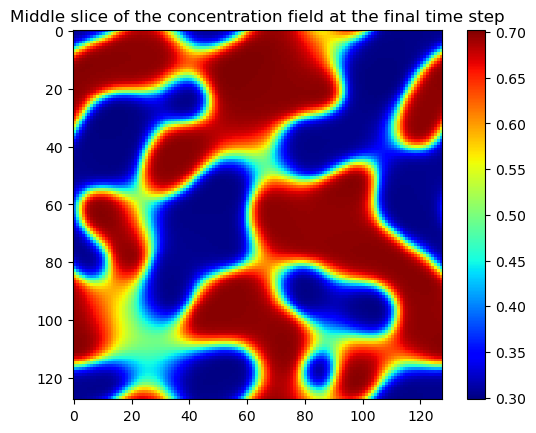

In [5]:
visualize_slice_cpu(c_init)

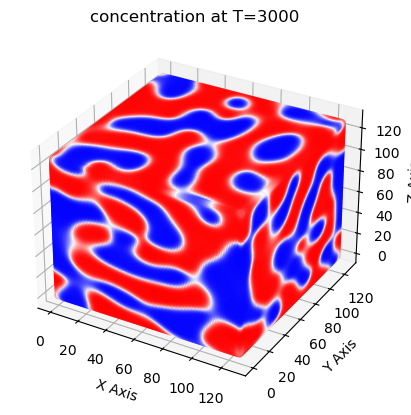

In [6]:
visualize_3d_cpu(c_init,3000)

<font color='blue'>**Section 2: Cupy GPU**</font>

In [7]:
##Method 2: Cupy GPU

class solver_CH():
    def __init__(self, rho, kappa, M, ca, cb, alpha):
        self.rho = rho
        self.kappa = kappa
        self.M = M
        self.ca = ca
        self.cb = cb
        self.alpha = alpha
        
    def dfchemdc(self,w):
        return 2.0*self.rho*(w-self.ca)*(w-self.cb)*(2.0*w-self.ca-self.cb)
        
    def Solve_CH(self, dt, dxx, c, ksq):
        c_fft = cp.fft.fftn(c)
        h_fft = cp.fft.fftn(self.dfchemdc(c))
        c_fft = ((1 + self.alpha*self.M*dt*ksq)*c_fft - self.M*dt*ksq*h_fft)/(1 + self.M*self.kappa*dt*ksq**2+self.alpha*self.M*dt*ksq)
        c_new = cp.fft.ifftn(c_fft).real
        return c_new   

def initial_cond(nx,ny,nz):
    c_init = 0.5 + cp.random.randn(nx, ny, nz)*0.05
#    c_init = 0.3 + np.random.uniform(-1,1,size=(nx,ny))*0.01
    return c_init

In [8]:
nx = 384
ny = 384
nz = 384

dx, dy, dz = 1.0, 1.0, 1.0
# Wavenumbers for the 3D spectral method
kx = cp.fft.fftfreq(nx, d=dx) * 2.0 * cp.pi
ky = cp.fft.fftfreq(ny, d=dy) * 2.0 * cp.pi
kz = cp.fft.fftfreq(nz, d=dz) * 2.0 * cp.pi
kx, ky, kz = cp.meshgrid(kx, ky, kz, indexing='ij')
ksq = cp.square(kx) + cp.square(ky) + cp.square(kz)


#c_new = cp.zeros((nx,ny,nz)) # zero clear
c_init = initial_cond(nx,ny,nz)

In [9]:
nsteps = 3000
Solver = solver_CH(5,2,5,0.3,0.7,0)
time_start=time.time()
for nstep in range(1,nsteps+1):
    c_init = Solver.Solve_CH(0.1,1,c_init,ksq)
#    c_init[:,:,:] = c_new[:,:,:]
time_end=time.time()
print('runnig time=',time_end-time_start)

runnig time= 185.3810362815857


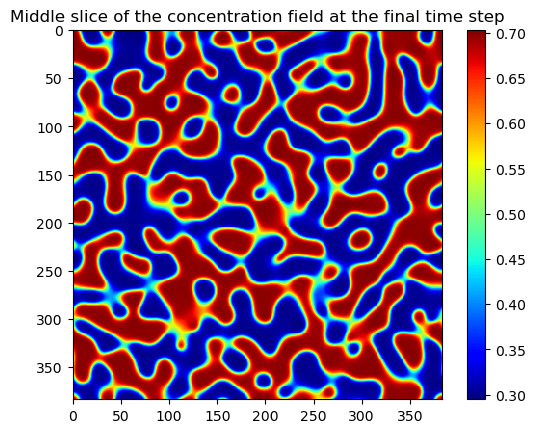

In [10]:
visualize_slice_gpu(c_init)

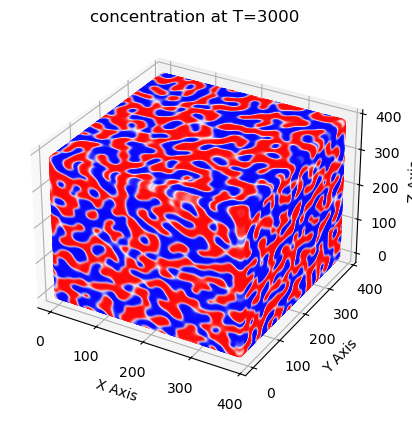

In [11]:
visualize_3d_gpu(c_init,3000)

<font color='blue'> **Section 3: Manually dispatching GPU** </font>

In [18]:
## Method 3: manually dispatch

# Define the CUDA kernel as a raw string for dfdc
update_dfdc = cp.RawKernel(r'''
extern "C" __global__
void update_dfdc(const double* c, double* dfdc, const double rho, const double ca, const double cb, \
    const int nx, const int ny, const int nz) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int k = blockDim.z * blockIdx.z + threadIdx.z;

    if (i >= nx || j >= ny || k >= nz) return;

    // Compute the index of the current element
    int idx = (k * ny + j) * nx + i;

    // Compute the dfdc
    double lap = 2.0 * rho * (c[idx] - ca) * (c[idx] - cb) * (2.0 * c[idx] - ca - cb);

    // Write the result to the output array
    dfdc[idx] = lap;
}
''', 'update_dfdc')



# Define the CUDA kernel for the 3D recipcol space calculation
update_cfft = cp.RawKernel(r'''
#include <cupy/complex.cuh>
extern "C" __global__
void update_cfft(complex<double>* c_fft, const complex<double>* h_fft, const double* ksq_flat,\
     const double alpha, const double kappa, const double M, \
     const double dt, const int nx, const int ny, const int nz) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int k = blockDim.z * blockIdx.z + threadIdx.z;
    
    if (i >= nx || j >= ny || k >= nz) return;
    
    // Compute the index of the current element
    int idx = (k * ny + j) * nx + i;

    // Compute the fft of c of next step
    complex<double> lap = ((1.0 + alpha*M*dt*ksq_flat[idx])*c_fft[idx] - M*dt*ksq_flat[idx]*h_fft[idx])/(1.0 + \
    M*kappa*dt*ksq_flat[idx]*ksq_flat[idx]+alpha*M*dt*ksq_flat[idx]);
    
    c_fft[idx] = lap;
}
''', 'update_cfft')


def dfchemdc(w,rho,ca,cb):
    return 2.0*rho*(w-ca)*(w-cb)*(2.0*w-ca-cb)
    
# Parameters for the 3D spectral method
# Parameters 
nx, ny, nz = 384, 384, 384  # Grid size for 3D
dx, dy, dz = cp.float64(1.0), cp.float64(1.0), cp.float64(1.0)  # Grid spacing for 3D 

M = cp.float64(5.0)  
kappa = cp.float64(2.0)  
rho = cp.float64(5.0)
dt = cp.float64(0.1)  
ca = cp.float64(0.3)
cb = cp.float64(0.7)
alpha = cp.float64(0.0)

# Initialize the concentration field 
c = initial_cond(nx,ny,nz)
dfdc = cp.empty_like(c)

# Allocate memory for the concentration in the spectral domain for 3D
c_fft = cp.fft.fftn(c)
#c_fftl = cp.empty_like(c_fft)

# Wavenumbers for the 3D spectral method
kx = cp.fft.fftfreq(nx, d=dx) * 2.0 * cp.pi
ky = cp.fft.fftfreq(ny, d=dy) * 2.0 * cp.pi
kz = cp.fft.fftfreq(nz, d=dz) * 2.0 * cp.pi
kx, ky, kz = cp.meshgrid(kx, ky, kz, indexing='ij')
ksq = cp.square(kx) + cp.square(ky) + cp.square(kz)
#ksq_flat = ksq.ravel()  # Flatten the array for use in the kernel


# Define block and grid sizes for the kernel launch for 3D
block_size_3d = (8, 8, 8)
grid_size_3d = ((nx + block_size_3d[0] - 1) // block_size_3d[0],
                (ny + block_size_3d[1] - 1) // block_size_3d[1],
                (nz + block_size_3d[2] - 1) // block_size_3d[2])

time_start=time.time()

# Time-stepping loop for 3D Cahn-Hilliard equation
for t in range(3000):   
    # Update dfdc
    update_dfdc(grid_size_3d, block_size_3d, (c.ravel(), dfdc, rho, ca, cb, nx, ny, nz))    
    #dfdc = dfchemdc(c,rho,ca,cb)
    # fft for dfdc
    h_fft = cp.fft.fftn(dfdc)  
    #Update cfft for next time
    update_cfft(grid_size_3d, block_size_3d, (c_fft, h_fft, ksq, alpha, kappa, M, dt, nx, ny, nz))
    #c_fft = ((1 + alpha*M*dt*ksq)*c_fft - M*dt*ksq*h_fft)/(1 + M*kappa*dt*ksq**2+alpha*M*dt*ksq)
    c = cp.fft.ifftn(c_fft).real
    
   
time_end=time.time()
print('runnig time=',time_end-time_start)

runnig time= 76.1536054611206


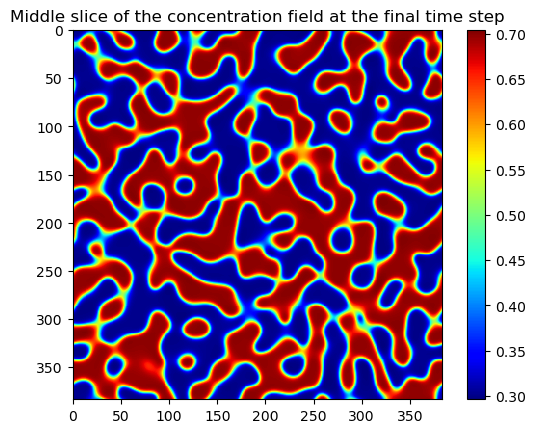

In [13]:
visualize_slice_gpu(c)

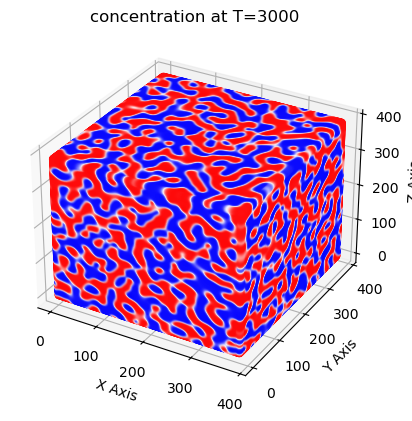

In [14]:
visualize_3d_gpu(c,3000)

<font color='blue'>**Section 4: Convex splitting (Testing with $\alpha \neq 0$ with bigger $\Delta t$)**</font>

In [22]:
alpha = cp.float64(2.5)
dt = cp.float64(1.0) 

c = initial_cond(nx,ny,nz)
c_fft = cp.fft.fftn(c)

time_start=time.time()

# Time-stepping loop for 3D Cahn-Hilliard equation
for t in range(3000):   
    # Update dfdc
    update_dfdc(grid_size_3d, block_size_3d, (c.ravel(), dfdc, rho, ca, cb, nx, ny, nz))    
    #dfdc = dfchemdc(c,rho,ca,cb)
    # fft for dfdc
    h_fft = cp.fft.fftn(dfdc)  
    #Update cfft for next time
    update_cfft(grid_size_3d, block_size_3d, (c_fft, h_fft, ksq, alpha, kappa, M, dt, nx, ny, nz))
    #c_fft = ((1 + alpha*M*dt*ksq)*c_fft - M*dt*ksq*h_fft)/(1 + M*kappa*dt*ksq**2+alpha*M*dt*ksq)
    c = cp.fft.ifftn(c_fft).real
    
   
time_end=time.time()
print('runnig time=',time_end-time_start)

runnig time= 76.31028532981873


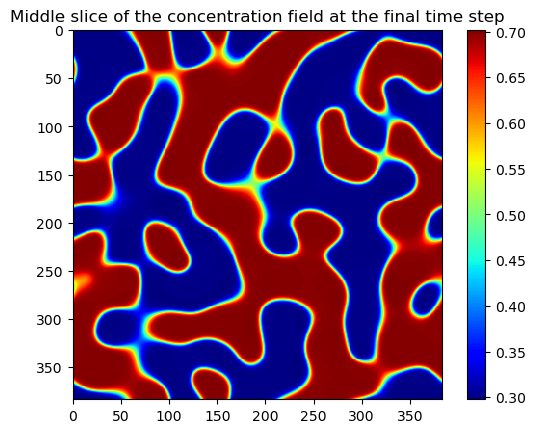

In [23]:
visualize_slice_gpu(c)